<a href="https://www.kaggle.com/code/yashmaini/road-analysis?scriptVersionId=216850368" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install osmnx networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.14.4
    Uninstalling geopandas-0.14.4:
      Successfully uninstalled geopandas-0.14.4


In [2]:
import osmnx as ox
import networkx as nx
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import plotly.express as px


In [3]:
def calculate_road_circularity(place_name, distance=5000):
    # Calculate the average and median circularity of roads in a given area.
    
    G = ox.graph_from_address(place_name, dist=distance, network_type='drive')  # Load the road network
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)  # Convert to GeoDataFrame

    circularities = []
    for edge in edges.geometry:
        if isinstance(edge, LineString):
            length = edge.length  # Length of the road
            start, end = edge.coords[0], edge.coords[-1]
            straight_line_distance = LineString([start, end]).length  # Straight-line distance

            if straight_line_distance > 0:
                circularities.append(length / straight_line_distance)  # Circularity

    return {
        "city": place_name,  # Name of the analyzed area
        "average_circularity": np.mean(circularities),  # Average circularity of roads
        "median_circularity": np.median(circularities),  # Median circularity of roads
        "num_segments": len(circularities),  # Number of road segments analyzed
    }


In [4]:
cities = ["Mumbai, India", "London, UK"] 
results = []
for city in cities:
  city_circularity = calculate_road_circularity(city)
  results.append(city_circularity)
  print(f"{city} Road Circularity: {city_circularity}")

Mumbai, India Road Circularity: {'city': 'Mumbai, India', 'average_circularity': 1.0670264159357474, 'median_circularity': 1.0, 'num_segments': 16237}
London, UK Road Circularity: {'city': 'London, UK', 'average_circularity': 1.048702557239139, 'median_circularity': 1.000157956220735, 'num_segments': 34740}


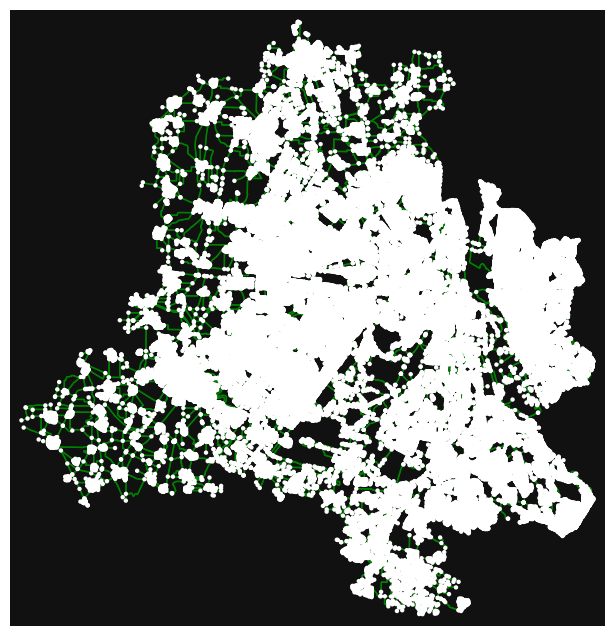

In [5]:
place = "Delhi, India"
graph = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(graph, node_size=10, edge_color="green")


Top 5 nodes by betweenness centrality:
Node 10598455898: 0.1412
Node 10598455893: 0.1303
Node 1869899501: 0.1280
Node 943640708: 0.1254
Node 943640939: 0.1091

Top 5 edges by betweenness centrality:
Edge (10598455893, 1869899501): 0.0759
Edge (9841262325, 10598455893): 0.0726
Edge (10598455896, 10598455899): 0.0640
Edge (10598455898, 943640708): 0.0636
Edge (6730511851, 6730511854): 0.0610


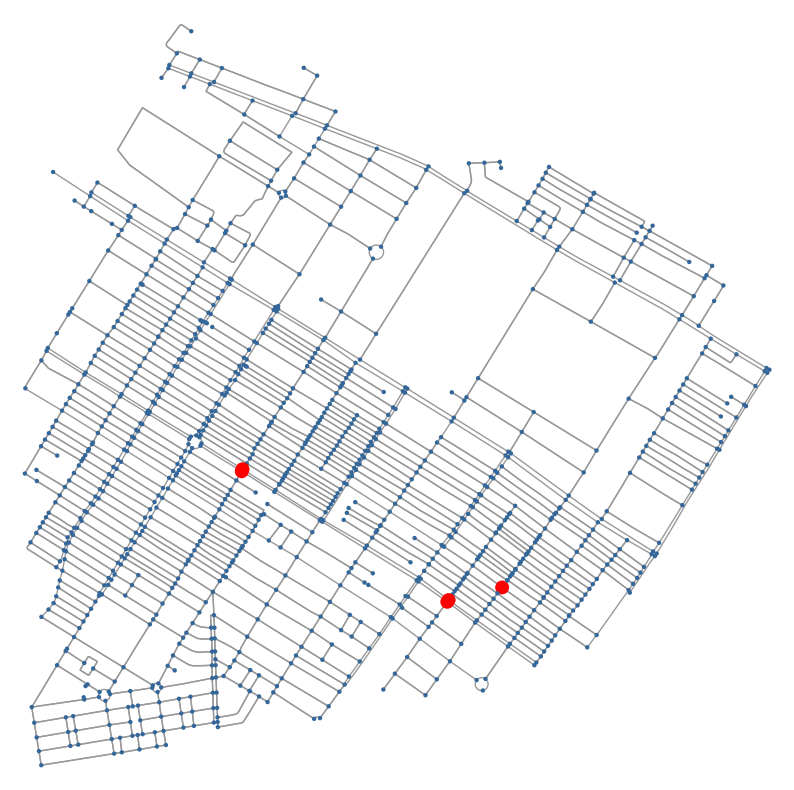

Text(0.5, 1.0, 'Delhi Road Network\nRed nodes indicate high betweenness centrality')

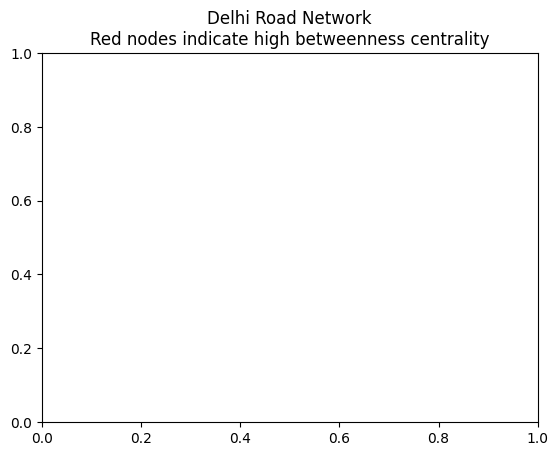

In [6]:
place = "Karol Bagh, Delhi, India"
graph = ox.graph_from_place(place, network_type='drive')

# Convert MultiDiGraph to DiGraph for centrality calculations
digraph = nx.DiGraph(graph)

# Calculate centralities
node_betweenness = nx.betweenness_centrality(digraph, normalized=True, weight='length')
edge_betweenness = nx.edge_betweenness_centrality(digraph, normalized=True, weight='length')

# Get top nodes and edges
top_nodes = sorted(node_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
top_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

# Print results with formatted output
print("\nTop 5 nodes by betweenness centrality:")
for node_id, centrality in top_nodes:
    print(f"Node {node_id}: {centrality:.4f}")

print("\nTop 5 edges by betweenness centrality:")
for edge, centrality in top_edges:
    print(f"Edge {edge}: {centrality:.4f}")

# Visualize the network with high betweenness nodes highlighted
nc = ['r' if node in dict(top_nodes) else '#336699' for node in digraph.nodes()]
ns = [100 if node in dict(top_nodes) else 10 for node in digraph.nodes()]

fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(graph, node_color=nc, node_size=ns, ax=ax)
plt.title("Delhi Road Network\nRed nodes indicate high betweenness centrality")